# Illustrate the Methodology

In [1]:
!pip install linearmodels

In [2]:
import numpy as np
import statsmodels.api as sm
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import time
from scipy.linalg import orth
from linearmodels.iv import IV2SLS
import xgboost as xgb
from scipy.optimize import leastsq,minimize
import seaborn as sns

np.random.seed(2024)

# Draw some means for each feature
means = np.random.uniform(-10,10,4)

V = 500 #################################
covariate_obs = np.column_stack((np.random.normal(means[0],1,V),
                         np.random.normal(means[1],1,V),
                         np.random.normal(means[2],1,V)))

covariate_unobs = np.random.normal(means[3],1,V)
graph_info = np.column_stack((covariate_obs[:,1:3],covariate_unobs))
dist_mat = distance_matrix(graph_info,graph_info)

A = (dist_mat<0.4).astype(int)

# Set the main diagonal to 0's
np.fill_diagonal(A,0)

T = np.random.choice([0,1],V,p=[0.5,0.5]) ####################
eps = np.random.normal(0,0.1,V)

# l-2 distance matrix (assumed known)
location = np.random.normal(0,3,V).reshape(V,1)
D = distance_matrix(location,location) # graph weights

# Weighted adjacency matrix
A_weighted = np.multiply(A,D)
B_weighted = np.diag(np.sum(A_weighted,1)**(0.5))
for i in range(V):
    if B_weighted[i,i] ==0:
        next
    else:
        B_weighted[i,i] = 1/B_weighted[i,i]

# Normalized A_weighted
G_weighted = B_weighted@A_weighted@B_weighted

In [3]:
alpha0 = 0.7683
beta0 = 0.4666
delta0 = 0.1507
treated = np.where(T==1)[0]
sigma = 1 # Kernel bandwidth
lam = 0.001 # kernel regularization term

alpha_hat = 0.1
beta_hat = 0.2 # must be in (-1,1)
delta_hat = 0.5

parameters = [alpha_hat,delta_hat,beta_hat]

# Generate 1 covariate
X = np.random.normal(3,1,V)

# Heterogeneous direct effect: f(x) #
fx = np.maximum(X-2,1-2*X-X**2)+np.sin(0.5*X**2)+np.piecewise(X, [X<1,X>=2,X>=4], [-1,5,1])
#fx = 3*X-0.5*X**2
fxZ = np.multiply(fx,T)

### Generate outcomes using reduced-form ###
IbG = np.linalg.matrix_power((np.diag(np.ones(V))-beta0*A_weighted),-1) #$$$$$$$$$$$$$$$ A<=>G_weighted
part1 = alpha0*IbG@np.ones(V)
part2 = IbG@fxZ
part3 = delta0*IbG@A_weighted@T  #$$$$$$$$$$$$$$$ A<=>G_weighted
Y = part1 + part2 + part3 + IbG@eps

### Compute kernel estimator $\hat f(x)$

In [4]:
# Kernel matrix
K = np.exp(-distance_matrix(X[treated].reshape(int(sum(T)),1),X[treated].reshape(int(sum(T)),1))**2/(2*sigma**2))

# Residual fxZ with initialization
Y_tilde = Y-alpha_hat*np.ones(V)-beta_hat*A_weighted@Y-delta_hat*A_weighted@T #$$$$$$$$$$$$$$$ A<=>G_weighted

# Compute kernel weights (using only treated)
C_hat = np.linalg.matrix_power(lam*np.diag(np.ones(int(sum(T))))+K,-1)@Y_tilde[treated]

# Evaluate the performance of K@C_hat, estimator for fx|Z=1
KC = K@C_hat
print('||Y^tilde-K@C^hat|| (for treated) =', np.linalg.norm(Y_tilde[treated]-KC))
rsq = 1-np.dot(fxZ[treated]-KC,fxZ[treated]-KC)/np.dot(fxZ[treated]-np.mean(fxZ[treated]),fxZ[treated]-np.mean(fxZ[treated]))
print('R-squared:',rsq)

||Y^tilde-K@C^hat|| (for treated) = 372.6633941632981
R-squared: -7.313886000517787


- In-sample fit

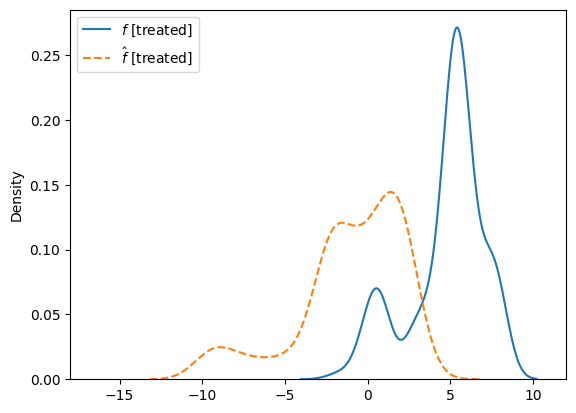

In [5]:
sns.kdeplot(fx[treated],label=r'$f$ [treated]')
sns.kdeplot(KC,linestyle='--',label=r'$\hat{f}$ [treated]')
plt.xlim(-18,12)
plt.legend(loc=2)

- Out-of-sample fit

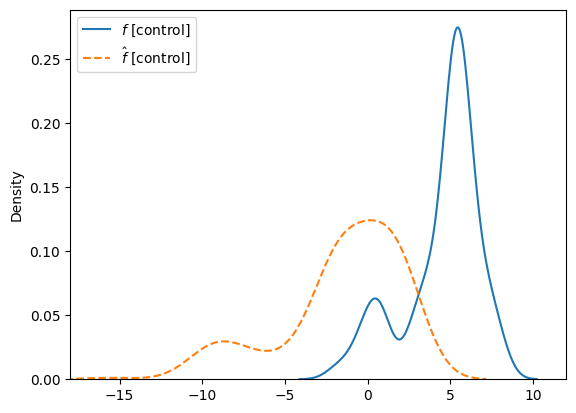

In [6]:
fx_hat = np.zeros(V)
fx_hat[treated] = KC

for i in range(V):
    if i not in treated:
        fx_hat[i] = np.exp(-(X[i]-X[treated])**2/(2*sigma**2))@C_hat
    next

sns.kdeplot(fx[np.setdiff1d(range(V),treated)],label=r'$f$ [control]')
sns.kdeplot(fx_hat[np.setdiff1d(range(V),treated)],linestyle='--',label=r'$\hat{f}$ [control]')
plt.xlim(-18,12)
plt.legend(loc=2)

### Proceed to update $\hat\alpha, \hat\beta,\hat\delta$ using $\hat{f}(x)$ --- IV Regression

In [7]:
# Construct fx for all X
fx_hat = np.zeros(V)
fx_hat[treated] = KC

# Build IVs and variables
q = 5
iv1 = [np.linalg.matrix_power(A_weighted,(k+2))@np.multiply(fx_hat,T) for k in range(q)] #$$$$$$$$$$$$$$$ A<=>G_weighted
iv2 = [np.linalg.matrix_power(A_weighted,(k+2))@T for k in range(q)] #$$$$$$$$$$$$$$$ A<=>G_weighted
ivs = np.column_stack((np.array(iv1).T,np.array(iv2).T))

exog = sm.add_constant(A_weighted@T) #$$$$$$$$$$$$$$$ A<=>G_weighted

# Run IV Reg
ivreg = IV2SLS(
            Y-np.multiply(fx_hat,T), # dependent variable
            exog, # exogenous regressors
            A_weighted@Y, # endogenous regressors #$$$$$$$$$$$$$$$ A<=>G_weighted
            instruments = ivs, # instrumental variables
            weights = None).fit(cov_type="unadjusted")
print(ivreg)

# Update the coefficients
alpha_hat,delta_hat,beta_hat = ivreg.params

np.column_stack((round(ivreg.params,4),[alpha0,delta0,beta0]))

                          IV-2SLS Estimation Summary                          
Dep. Variable:              dependent   R-squared:                      0.9625
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9623
No. Observations:                 500   F-statistic:                    119.05
Date:                Fri, Apr 11 2025   P-value (F-stat)                0.0000
Time:                        18:29:17   Distribution:                  chi2(2)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog.0         2.9519     0.4160     7.0954     0.0000      2.1365      3.7673
exog.1         0.1322     0.0479     2.7591     0.00

array([[2.9519, 0.7683],
       [0.1322, 0.1507],
       [0.3854, 0.4666]])

# Alternate the above

In [8]:
iteration = 1

while True:
    Y_tilde = Y-alpha_hat*np.ones(V)-beta_hat*A_weighted@Y-delta_hat*A_weighted@T #$$$$$$$$$$$$$$$ A<=>G_weighted
    C_hat = np.linalg.matrix_power(lam*np.diag(np.ones(int(sum(T))))+K,-1)@Y_tilde[treated]
    KC = K@C_hat

    rsq_new = 1-np.dot(fxZ[treated]-KC,fxZ[treated]-KC)/np.dot(fxZ[treated]-np.mean(fxZ[treated]),fxZ[treated]-np.mean(fxZ[treated]))

    fx_hat = np.zeros(V)
    fx_hat[treated] = KC

    for i in range(V):
        if i not in treated:
            fx_hat[i] = np.exp(-(X[i]-X[treated])**2/2/sigma**2)@C_hat
        next

    q = 5            ##########################################
    iv1 = [np.linalg.matrix_power(A_weighted,(k+2))@np.multiply(fx_hat,T) for k in range(q)] #$$$$$$$$$$$$$$$ A<=>G_weighted
    iv2 = [np.linalg.matrix_power(A_weighted,(k+2))@T for k in range(q)] #$$$$$$$$$$$$$$$ A<=>G_weighted
    ivs = np.column_stack((np.array(iv1).T,np.array(iv2).T))

    exog = sm.add_constant(A_weighted@T) #$$$$$$$$$$$$$$$ A<=>G_weighted

    ivreg = IV2SLS(
                Y-np.multiply(fx_hat,T), # dependent variable
                exog, # exogenous regressors
                A_weighted@Y, # endogenous regressors #$$$$$$$$$$$$$$$ A<=>G_weighted
                instruments = ivs, # instrumental variables
                weights = None).fit(cov_type="unadjusted")

    #print(np.column_stack((round(ivreg.params,4),[alpha0,delta0,beta0])))
    alpha_hat,delta_hat,beta_hat = ivreg.params
    parameters = np.column_stack((parameters,ivreg.params))
    iteration += 1

    if abs(rsq_new-rsq)<0.0000001:
        print('R-squared:',round(rsq_new,4))
        print("Estimation converged")
        break
    rsq = rsq_new

R-squared: 0.9255
Estimation converged


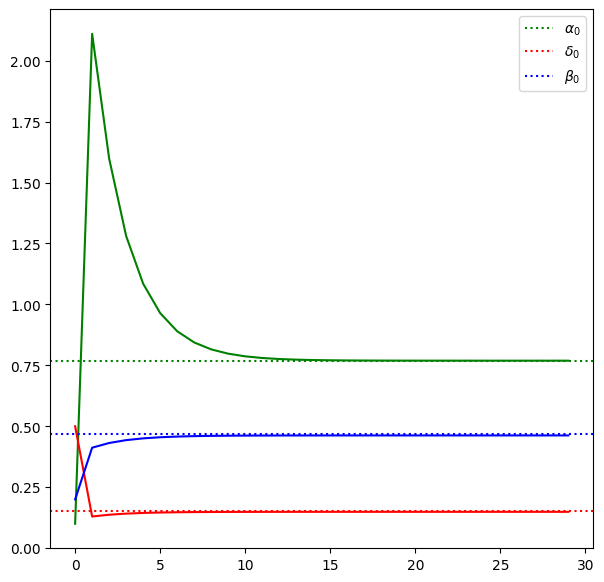

In [9]:
plt.figure(figsize=(7,7))
plt.plot(range(iteration),parameters[0,:],color='g')
plt.axhline(alpha0, color='g',linestyle=':',label=r'$\alpha_0$')

plt.plot(range(iteration),parameters[1,:],color='r')
plt.axhline(delta0, color='r',linestyle=':',label=r'$\delta_0$')

plt.plot(range(iteration),parameters[2,:],color='b')
plt.axhline(beta0, color='b',linestyle=':',label=r'$\beta_0$')
plt.legend(loc=1)

## Diagnostics

### 1. Distribution of $U\equiv Y-f(x)\circ Z-\hat\alpha\vec{1}-\hat\beta GY$

- Overestimation of $\hat\alpha$ and $\hat\beta$ leads to $\hat\delta<\delta_0$.

In [10]:
[alpha_hat,alpha0],[beta_hat,beta0],[delta_hat,delta0]

([0.7691600785653104, 0.7683],
 [0.46247959834738583, 0.4666],
 [0.14907278593399473, 0.1507])

- In theory: $\mathbb{E}[U-\delta_0 GZ]=\mathbb{E}[\epsilon]=0$

-0.007177794642932342


<Axes: ylabel='Density'>

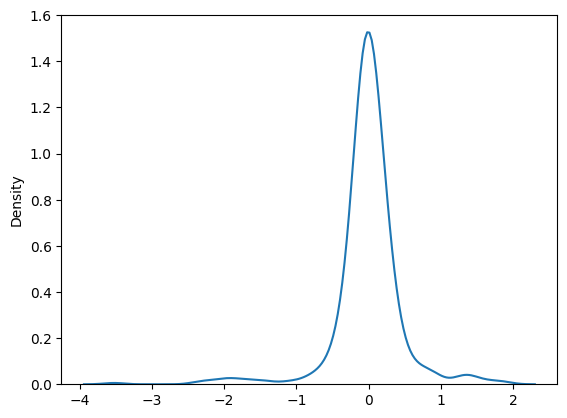

In [11]:
U = Y-np.multiply(fx_hat,T)-alpha_hat*np.ones(V)-beta_hat*A_weighted@Y #$$$$$$$$$$$$$$$ A<=>G_weighted
print(np.mean(U-delta0*A_weighted@T)) #$$$$$$$$$$$$$$$ A<=>G_weighted
sns.kdeplot(U-delta0*A_weighted@T) #$$$$$$$$$$$$$$$ A<=>G_weighted

### 2. Kernel extrapolation

In [12]:
fx_hat = np.zeros(V)
fx_hat[treated] = KC

for i in range(V):
    if i not in treated:
        fx_hat[i] = np.exp(-(X[i]-X[treated])**2/(2*sigma**2))@C_hat
    next

- Treated

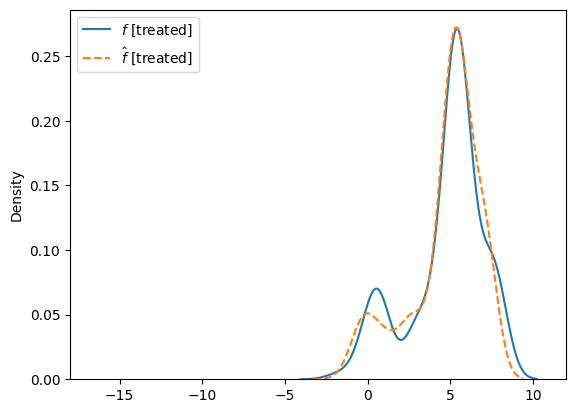

In [13]:
sns.kdeplot(fx[treated],label=r'$f$ [treated]')
sns.kdeplot(fx_hat[treated],linestyle='--',label=r'$\hat{f}$ [treated]')
plt.xlim(-18,12)
plt.legend(loc=2)

- Untreated (out-of-sample)

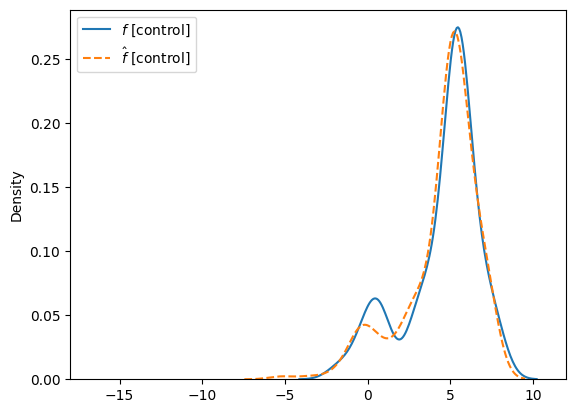

In [14]:
sns.kdeplot(fx[np.setdiff1d(range(V),treated)],label=r'$f$ [control]')
sns.kdeplot(fx_hat[np.setdiff1d(range(V),treated)],linestyle='--',label=r'$\hat{f}$ [control]')
plt.xlim(-18,12)
plt.legend(loc=2)

### 3. Sparsity of weighted $G$

<Axes: ylabel='Density'>

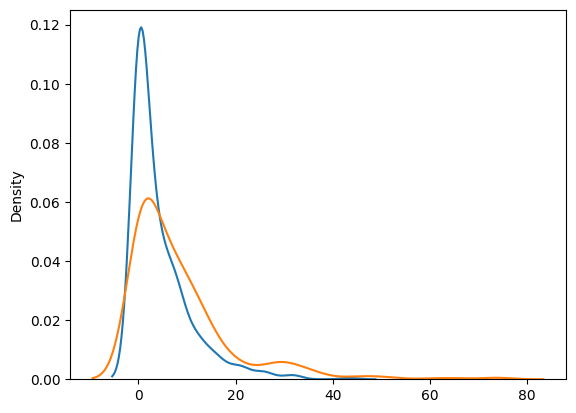

In [15]:
sns.kdeplot(A_weighted@T) #$$$$$$$$$$$$$$$ A<=>G_weighted
sns.kdeplot(A_weighted@np.ones(V)) #$$$$$$$$$$$$$$$ A<=>G_weighted

In [16]:
np.cov(np.column_stack((A_weighted@T,A@T,G_weighted@T)).T)

array([[38.97011799,  8.03501427,  1.40821886],
       [ 8.03501427,  2.59440481,  0.38158727],
       [ 1.40821886,  0.38158727,  0.1496106 ]])